In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import os, sys

# Data

## Kidney

In [2]:
kidney_df = pd.read_csv('kidney_allFrames.csv')
kidney_df.head()

,timestamp,stay_id,anchor_age,patientweight,los,gender,alb,aniongap,bun,crp,...,paralytics,sedation,tpnutrition,vasoactive,vasopressors,vent,hours-k-iv,hours-mg-noniv,hours-p-iv,hours-mg-iv
0,2144-02-22 21:00:00,31055329,48,74.4,2.774931,0,0.0,21.0,130.0,249.7,...,0,2,0,0,0,0,NaN,NaN,NaN,NaN
1,2144-02-23 03:00:00,31055329,48,74.4,2.774931,0,0.0,21.0,130.0,249.7,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
2,2144-02-23 09:00:00,31055329,48,74.4,2.774931,0,0.0,23.0,130.0,258.2,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
3,2144-02-23 15:00:00,31055329,48,74.4,2.774931,0,0.0,23.0,130.0,258.2,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
4,2144-02-23 21:00:00,31055329,48,74.4,2.774931,0,0.0,23.0,132.0,258.2,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN


In [3]:
cohort = pd.read_csv("data/mimic-iv-1.0/icu/icustays.csv.gz", compression='gzip')
diagnoses_icd = pd.read_csv("data/mimic-iv-1.0/hosp/diagnoses_icd.csv.gz", compression='gzip')

TRANSPLANT_CODES = ['0091', '0092', '0093', '02Y', '02YA0Z0', '02YA0Z1', 
                    '02YA0Z2', '0794', '07Y', '07YM0Z0', '07YM0Z1', '07YM0Z2', 
                    '07YP0Z0', '07YP0Z1', '07YP0Z2', '0BYM0Z0', '0BYM0Z1', 
                    '0BY', '0BYC0Z0', '0BYC0Z1', '0BYC0Z2', '0BYD0Z0', '0BYD0Z1', 
                    '0BYD0Z2', '0BYF0Z0', '0BYF0Z1', '0BYF0Z2', '0BYG0Z0', '0BYG0Z1', 
                    '0BYG0Z2', '0BYH0Z0', '0BYH0Z1', '0BYH0Z2', '0BYJ0Z0', '0BYJ0Z1',
                    '0BYJ0Z2', '0BYK0Z0', '0BYK0Z1', '0BYK0Z2', '0BYL0Z0', '0BYL0Z1', 
                    '0BYL0Z2', '0BYM0Z2', '0DY', '0DY50Z0', '0DY50Z1', '0DY50Z2', 
                    '0DY60Z0', '0DY60Z1', '0DY60Z2', '0DY80Z0', '0DY80Z1', '0DY80Z2',
                    '0DYE0Z0', '0DYE0Z1', '0DYE0Z2', '0FY', '0FY00Z0', '0FY00Z1', 
                    '0FY00Z2', '0FYG0Z0', '0FYG0Z1', '0FYG0Z2', '0TY', '0TY00Z0',
                    '0TY00Z1', '0TY00Z2', '0TY10Z0', '0TY10Z1', '0TY10Z2', '0UY',
                    '0UY00Z0', '0UY00Z1', '0UY00Z2', '0UY10Z0', '0UY10Z1', '0UY10Z2', 
                    '0UY90Z0', '0UY90Z1', '0UY90Z2', '0WY', '0WY20Z0', '0WY20Z1', '0XY', 
                    '0XYJ0Z0', '0XYJ0Z1', '0XYK0Z0', '0XYK0Z1', '10Y', '10Y03ZE', 
                    '10Y03ZF', '10Y03ZG', '10Y03ZH', '10Y03ZJ', '10Y03ZK', '10Y03ZL', 
                    '10Y03ZM', '10Y03ZN', '10Y03ZP', '10Y03ZQ', '10Y03ZR', '10Y03ZS', 
                    '10Y03ZT', '10Y03ZV', '10Y03ZY', '10Y04ZE', '10Y04ZF', '10Y04ZG', 
                    '10Y04ZH', '10Y04ZJ', '10Y04ZK', '10Y04ZL', '10Y04ZM', '10Y04ZN', 
                    '10Y04ZP', '10Y04ZQ', '10Y04ZR', '10Y04ZS', '10Y04ZT', '10Y04ZV', 
                    '10Y04ZY', '10Y07ZE', '10Y07ZF', '10Y07ZG', '10Y07ZH', '10Y07ZJ', 
                    '10Y07ZK', '10Y07ZL', '10Y07ZM', '10Y07ZN', '10Y07ZP', '10Y07ZQ', 
                    '10Y07ZR', '10Y07ZS', '10Y07ZT', '10Y07ZV', '10Y07ZY', '1160', 
                    '1169', '3350', '3351', '3352', '336', '3751', '4100', '4101', 
                    '4102', '4103', '4104', '4106', '4107', '4108', '4109', '4191', 
                    '4194', '4697', '4974', '5051', '5059', '5280', '5282', '5283', 
                    '5284', '5285', '5286', '5553', '5561', '5569', '6353', '6592',
                    '8256', '8258', '8375', '8377', '8664', '5855']

hadm_ids_w_transplants = diagnoses_icd[diagnoses_icd.icd_code.isin(TRANSPLANT_CODES)].hadm_id.unique()
stay_ids_w_transplants = cohort[cohort.hadm_id.isin(hadm_ids_w_transplants)].stay_id.unique()
kidney_df['transplant'] = 0
transplant_indices = kidney_df[kidney_df.stay_id.isin(stay_ids_w_transplants)].index
kidney_df.loc[transplant_indices, 'transplant'] = 1

## Flu/Pneumonia

In [11]:
resp_df = pd.read_csv('flu_pneum_allFrames.csv')
procs = pd.read_csv("data/mimic-iv-1.0/icu/procedureevents.csv.gz", compression='gzip')
resp_df = resp_df.drop(columns=['vent'])
resp_df.head()

,timestamp,stay_id,anchor_age,patientweight,los,gender,alb,aniongap,bun,crp,...,pnutrition,ponutrition,packedrbc,paralytics,sedation,tpnutrition,vasoactive,vasopressors,hours-p-iv,hours-mg-iv
0,2143-07-29 10:00:00,39439439,48,69.0,2.051157,0,0.0,25.0,136.0,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,2143-07-29 16:00:00,39439439,48,69.0,2.051157,0,0.0,24.0,121.0,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,2143-07-29 22:00:00,39439439,48,69.0,2.051157,0,2.9,21.0,101.0,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,2143-07-30 04:00:00,39439439,48,69.0,2.051157,0,2.9,21.0,101.0,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,2143-07-30 10:00:00,39439439,48,69.0,2.051157,0,2.9,21.0,75.0,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [12]:
inputevents = pd.read_csv("data/mimic-iv-1.0/icu/inputevents.csv.gz", compression='gzip')

vent = procs[procs['itemid'] == 225792]
ventilated_stay_ids = vent.stay_id.unique()
resp_df['ventilated'] = 0

ventilated_indices = resp_df[resp_df.stay_id.isin(ventilated_stay_ids)].index
resp_df.loc[ventilated_indices, 'ventilated'] = 1

# Sklearn Gradient Boosting Classifier (Mortality Prediction)

In [13]:
TRAIN_COLS = ['anchor_age', 'patientweight', 'los', 'gender',
       'alb', 'aniongap', 'bun', 'crp', 'ca', 'chloride', 'creatinine',
       'fibrinogen', 'glucose', 'hgb', 'k', 'mg', 'na', 'p', 'platelets',
       'troponin', 'wbc', 'apneainterval', 'artco2p', 'arto2p', 'expratio',
       'hr', 'inspratio', 'insptime', 'nibpd', 'nibpm', 'nibps', 'pip', 'rr',
       'spo2', 'temp', 'urine', 'vm', 'vt', 'betablockers', 'ca-iv',
       'ca-noniv', 'cablockers', 'dextrose', 'fluids', 'insulin', 'k-iv',
       'hours-k-iv', 'loopdiuretics', 'mg-iv', 'mg-noniv', 'hours-mg-noniv',
       'p-iv', 'p-noniv', 'pnutrition', 'ponutrition', 'packedrbc',
       'paralytics', 'sedation', 'tpnutrition', 'vasoactive', 'vasopressors',
       'hours-p-iv']

DISEASE = 'resp'

if DISEASE == 'kidney':
    pred_var = 'transplant'
    X = kidney_df[TRAIN_COLS]
    y = kidney_df[pred_var]
else:
    pred_var = 'ventilated'
    X = resp_df[TRAIN_COLS]
    y = resp_df[pred_var]
    
X = X.fillna(-1)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

optimal_params = {'learning_rate': 0.359, 
                  'max_depth': 10,
                  'n_estimators': 50,
                  'min_samples_split': 4,
                  'random_state': 0}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(**optimal_params).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9787885929766674

# Sklearn Gradient Boosting Regressor (Length of Stay Prediction)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

TRAIN_COLS = ['anchor_age', 'patientweight', 'gender',
       'alb', 'aniongap', 'bun', 'crp', 'ca', 'chloride', 'creatinine',
       'fibrinogen', 'glucose', 'hgb', 'k', 'mg', 'na', 'p', 'platelets',
       'troponin', 'wbc', 'apneainterval', 'artco2p', 'arto2p', 'expratio',
       'hr', 'inspratio', 'insptime', 'nibpd', 'nibpm', 'nibps', 'pip', 'rr',
       'spo2', 'temp', 'urine', 'vm', 'vt', 'betablockers', 'ca-iv',
       'ca-noniv', 'cablockers', 'dextrose', 'fluids', 'insulin', 'k-iv',
       'hours-k-iv', 'loopdiuretics', 'mg-iv', 'mg-noniv', 'hours-mg-noniv',
       'p-iv', 'p-noniv', 'pnutrition', 'ponutrition', 'packedrbc',
       'paralytics', 'sedation', 'tpnutrition', 'vasoactive', 'vasopressors',
       'hours-p-iv']

pred_var = 'los'

if DISEASE == 'kidney':
    X = kidney_df[TRAIN_COLS]
else:
    X = resp_df[TRAIN_COLS]
    
X = X.fillna(-1)
y = resp_df[pred_var]

In [17]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 2.7699


### Plot feature importance

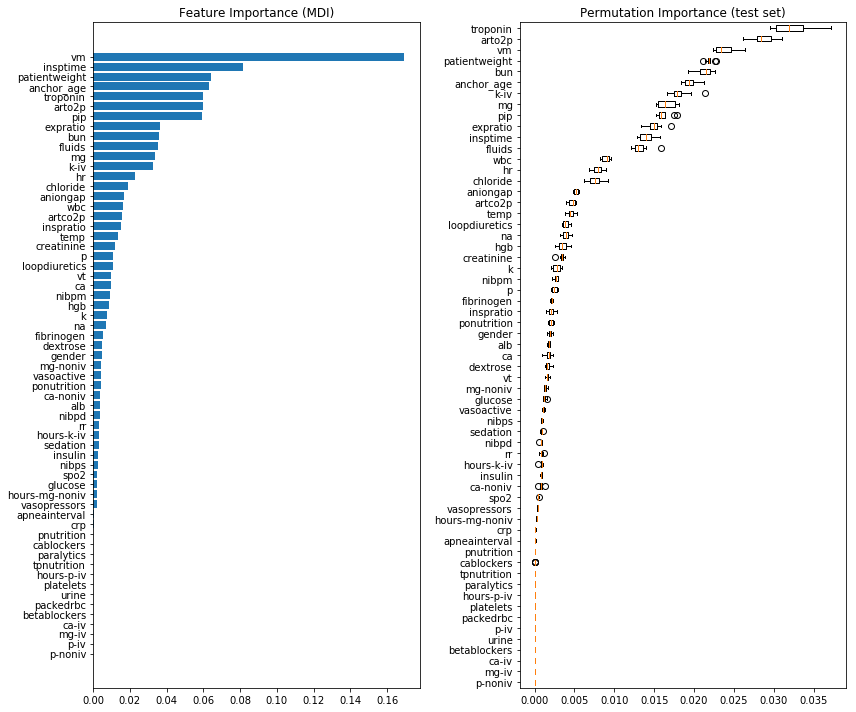

In [18]:
from sklearn.inspection import permutation_importance

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()


# XG-Boost If we want to be fancy

In [ ]:
import xgboost as xgb

TRAIN_COLS = ['anchor_age', 'patientweight', 'gender',
       'alb', 'aniongap', 'bun', 'crp', 'ca', 'chloride', 'creatinine',
       'fibrinogen', 'glucose', 'hgb', 'k', 'mg', 'na', 'p', 'platelets',
       'troponin', 'wbc', 'apneainterval', 'artco2p', 'arto2p', 'expratio',
       'hr', 'inspratio', 'insptime', 'nibpd', 'nibpm', 'nibps', 'pip', 'rr',
       'spo2', 'temp', 'urine', 'vm', 'vt', 'betablockers', 'ca-iv',
       'ca-noniv', 'cablockers', 'dextrose', 'fluids', 'insulin', 'k-iv',
       'hours-k-iv', 'loopdiuretics', 'mg-iv', 'mg-noniv', 'hours-mg-noniv',
       'p-iv', 'p-noniv', 'pnutrition', 'ponutrition', 'packedrbc',
       'paralytics', 'sedation', 'tpnutrition', 'vasoactive', 'vasopressors',
       'hours-p-iv',  'deceased']

pred_var = 'los'

X = kidney_df[TRAIN_COLS]
X = X.fillna(-1)
y = kidney_df[pred_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

In [ ]:
ypred = bst.predict(dtest)

In [ ]:
xgb.plot_importance(bst)

In [ ]:
xgb.plot_tree(bst, num_trees=2)